<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-Linear-GAN-with-batch-normalization" data-toc-modified-id="Simple-Linear-GAN-with-batch-normalization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple Linear GAN with batch normalization</a></span></li><li><span><a href="#Getting-Started--With-imports" data-toc-modified-id="Getting-Started--With-imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting Started  With imports</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Noise-Generation" data-toc-modified-id="Noise-Generation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Noise Generation</a></span></li><li><span><a href="#loss-Function" data-toc-modified-id="loss-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>loss Function</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training</a></span></li></ul></div>

# Simple Linear GAN with batch normalization

[PyTorch documentation](https://pytorch.org/docs/stable/index.html) 

# Getting Started  With imports



In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.cuda.empty_cache()
torch.manual_seed(0)
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    #plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    return plt.imshow(image_grid.permute(1, 2, 0).squeeze())

**Data used : MNIST Dataset**
The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9.

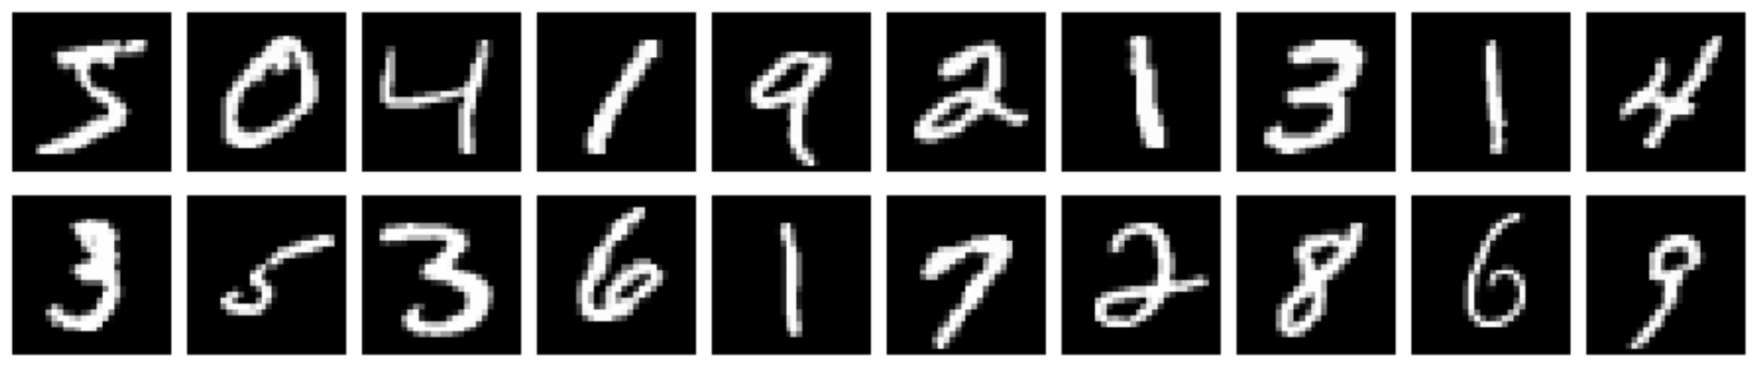

# Generator 

**Generator  Blocks**
the block consist of one Hidden layer, followed by Batch Normalization then one relu activation

**Generator Module**
consist of 4 blocks means 4 Hidden layers each layer followed by Batch Normalization relu activation the output layer ( linear and sigmoid activation).

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.block(z_dim, hidden_dim),
            self.block(hidden_dim, hidden_dim * 2),
            self.block(hidden_dim * 2, hidden_dim * 4),
            self.block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def block(self,input_dim, output_dim):
        return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True) 
                        )
    
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    

# Discriminator

**Discriminator  Blocks**
the block consist of one Hidden layer and one Leaky-relu activation.

**Discriminator Module**
consist of 3 blocks means 3 Hidden layers each layer followed by Leaky-relu activation the output linear layer.

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.block(im_dim, hidden_dim * 4),
            self.block(hidden_dim * 4, hidden_dim * 2),
            self.block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
        
    def block(self,input_dim, output_dim):
        return nn.Sequential(
         nn.Linear(input_dim, output_dim), 
         nn.Dropout(p=0.4, inplace=True),
         nn.LeakyReLU(0.2, inplace=True)
                        )
    
    def forward(self, image):
        return self.disc(image)

# Noise Generation

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)


# loss Function

In [5]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [6]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

# Training

*   criterion: the loss function
*   n_epochs: the number of times you iterate through the entire dataset when training
*   z_dim: the dimension of the noise vector
*   display_epoch: how often to display/visualize the images
*   batch_size: the number of images per forward/backward pass
*   lr: the learning rate
*   device: using a GPU (CUDA)

In [7]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_epoch = 5
batch_size = 512

lr = 0.00001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load MNIST dataset as tensors
dataloader = DataLoader( MNIST('.', download=False, transform=transforms.ToTensor()),
                            batch_size=batch_size,
                            shuffle=True)
steps_per_ep =len(dataloader)
gen = Generator(z_dim,784, 128).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(784, 128).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

gen_loss = False
error = False

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1 ,Step:117 ,Generator loss: 0.8245093559814712 ,discriminator loss: 0.6330362725055826


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2 ,Step:235 ,Generator loss: 1.2437440025604376 ,discriminator loss: 0.45626296557612345


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3 ,Step:353 ,Generator loss: 1.638467045153602 ,discriminator loss: 0.31633212606785643


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4 ,Step:471 ,Generator loss: 1.7667130545034249 ,discriminator loss: 0.3181027618505188


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5 ,Step:589 ,Generator loss: 1.6988496103529211 ,discriminator loss: 0.34576048714629687


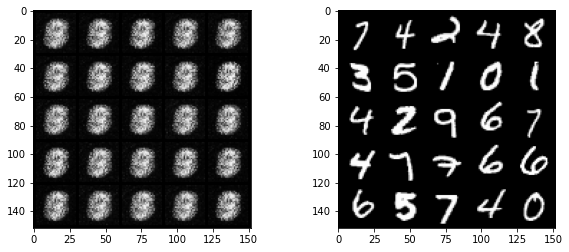

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6 ,Step:707 ,Generator loss: 1.7166143302190102 ,discriminator loss: 0.3293252572164697


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7 ,Step:825 ,Generator loss: 1.8263701644994441 ,discriminator loss: 0.2848692399970555


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8 ,Step:943 ,Generator loss: 1.980074420823889 ,discriminator loss: 0.2334157401474857


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9 ,Step:1061 ,Generator loss: 2.026533120769565 ,discriminator loss: 0.2104254981218758


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 ,Step:1179 ,Generator loss: 2.05009213847629 ,discriminator loss: 0.19479671853073577


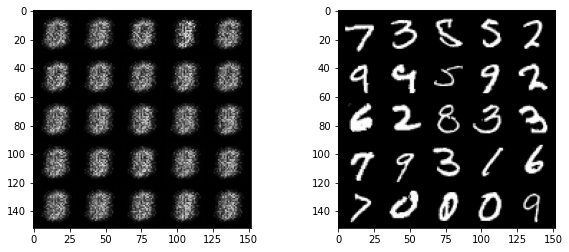

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 11 ,Step:1297 ,Generator loss: 2.000507076918069 ,discriminator loss: 0.20003128455857094


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 12 ,Step:1415 ,Generator loss: 1.8000906604831506 ,discriminator loss: 0.23645404776779258


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 13 ,Step:1533 ,Generator loss: 1.6583529367285261 ,discriminator loss: 0.2617255081817254


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 14 ,Step:1651 ,Generator loss: 1.5850983757083696 ,discriminator loss: 0.2636418432249861


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 15 ,Step:1769 ,Generator loss: 1.5029415397320762 ,discriminator loss: 0.2749882138381569


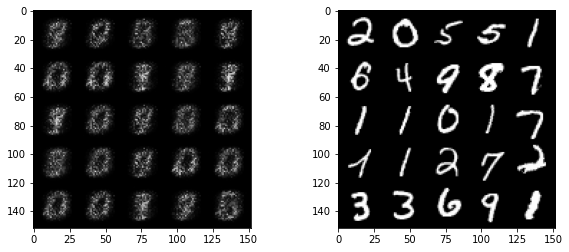

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 16 ,Step:1887 ,Generator loss: 1.4444689184932389 ,discriminator loss: 0.2846643997956131


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 17 ,Step:2005 ,Generator loss: 1.4121798913357622 ,discriminator loss: 0.28460365129729454


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 18 ,Step:2123 ,Generator loss: 1.435769587250079 ,discriminator loss: 0.2732348199618065


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 19 ,Step:2241 ,Generator loss: 1.4706735257375034 ,discriminator loss: 0.2656356989074561


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 20 ,Step:2359 ,Generator loss: 1.4385843640666887 ,discriminator loss: 0.2772828931525601


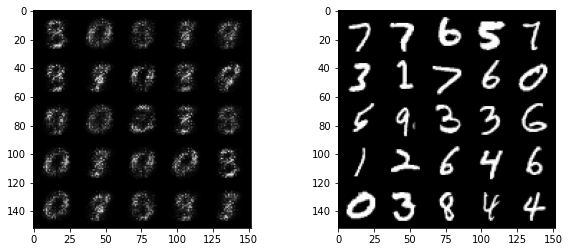

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 21 ,Step:2477 ,Generator loss: 1.4636100399292122 ,discriminator loss: 0.27188648573927954


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 22 ,Step:2595 ,Generator loss: 1.5512626615621277 ,discriminator loss: 0.2569713054572122


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 23 ,Step:2713 ,Generator loss: 1.7070631182799905 ,discriminator loss: 0.22127267049025678


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 24 ,Step:2831 ,Generator loss: 1.7719694941730824 ,discriminator loss: 0.2125891430650726


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 25 ,Step:2949 ,Generator loss: 1.818417959294077 ,discriminator loss: 0.2125259242573027


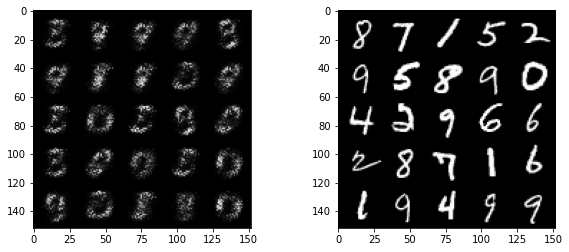

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 26 ,Step:3067 ,Generator loss: 1.8758490317958902 ,discriminator loss: 0.21285539006782783


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 27 ,Step:3185 ,Generator loss: 1.8970478773117065 ,discriminator loss: 0.22122859222404023


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 28 ,Step:3303 ,Generator loss: 2.0641875873177744 ,discriminator loss: 0.19295393763962432


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 29 ,Step:3421 ,Generator loss: 2.2183379783468724 ,discriminator loss: 0.17357636596691814


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 30 ,Step:3539 ,Generator loss: 2.34686670667034 ,discriminator loss: 0.16218501733521284


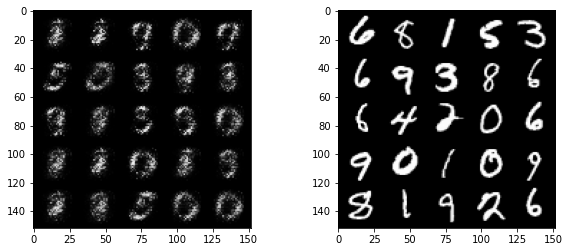

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 31 ,Step:3657 ,Generator loss: 2.305812581110809 ,discriminator loss: 0.17224202128285068


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 32 ,Step:3775 ,Generator loss: 2.379457265643751 ,discriminator loss: 0.16950396726192052


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 33 ,Step:3893 ,Generator loss: 2.5795786623227386 ,discriminator loss: 0.15177649436360696


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 34 ,Step:4011 ,Generator loss: 2.610497018038218 ,discriminator loss: 0.1545873560895354


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 35 ,Step:4129 ,Generator loss: 2.5653661408666837 ,discriminator loss: 0.17127985557762238


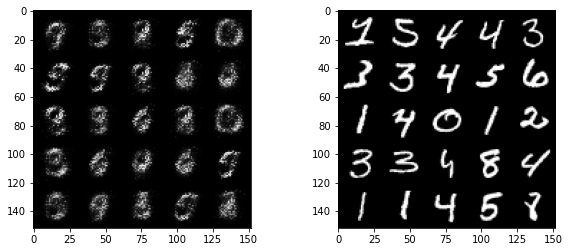

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 36 ,Step:4247 ,Generator loss: 2.6446913945472845 ,discriminator loss: 0.15879176620204571


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 37 ,Step:4365 ,Generator loss: 2.7188628245208224 ,discriminator loss: 0.14730397334038195


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 38 ,Step:4483 ,Generator loss: 2.77299608214427 ,discriminator loss: 0.1490891443218215


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 39 ,Step:4601 ,Generator loss: 2.9129259646949106 ,discriminator loss: 0.1375711422603009


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 40 ,Step:4719 ,Generator loss: 2.915670661602989 ,discriminator loss: 0.14186663805680755


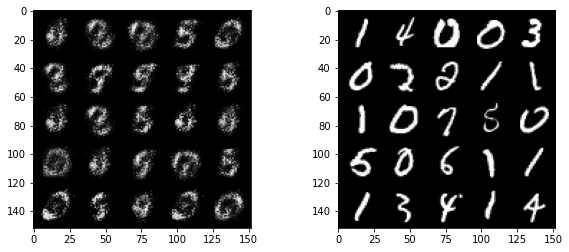

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 41 ,Step:4837 ,Generator loss: 2.865174372317426 ,discriminator loss: 0.1417507526733108


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 42 ,Step:4955 ,Generator loss: 2.933982269238619 ,discriminator loss: 0.13194737229811943


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 43 ,Step:5073 ,Generator loss: 3.0335617045224725 ,discriminator loss: 0.11734202346306737


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 44 ,Step:5191 ,Generator loss: 3.034625198881504 ,discriminator loss: 0.12733272122124498


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 45 ,Step:5309 ,Generator loss: 3.103770003480426 ,discriminator loss: 0.1372648505967552


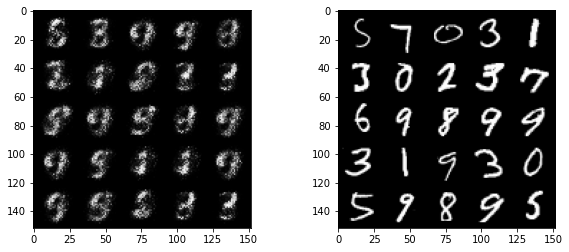

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 46 ,Step:5427 ,Generator loss: 3.1381210896928424 ,discriminator loss: 0.1403623066716275


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 47 ,Step:5545 ,Generator loss: 3.1273614370216745 ,discriminator loss: 0.1394615338767989


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 48 ,Step:5663 ,Generator loss: 3.1178876626289496 ,discriminator loss: 0.13295795231805013


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 49 ,Step:5781 ,Generator loss: 3.1744543536234713 ,discriminator loss: 0.12338719453852055


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 50 ,Step:5899 ,Generator loss: 3.2871629424014333 ,discriminator loss: 0.11329912028070221


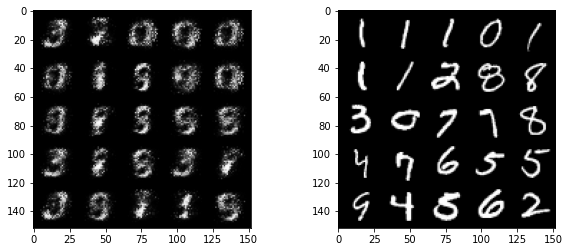

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 51 ,Step:6017 ,Generator loss: 3.387760275501316 ,discriminator loss: 0.10550069127042415


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 52 ,Step:6135 ,Generator loss: 3.548626277406336 ,discriminator loss: 0.09326505357936277


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 53 ,Step:6253 ,Generator loss: 3.5288146835262504 ,discriminator loss: 0.1025665742108378


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 54 ,Step:6371 ,Generator loss: 3.5306797613531855 ,discriminator loss: 0.10747448658033949


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 55 ,Step:6489 ,Generator loss: 3.629776857667049 ,discriminator loss: 0.09456460259981077


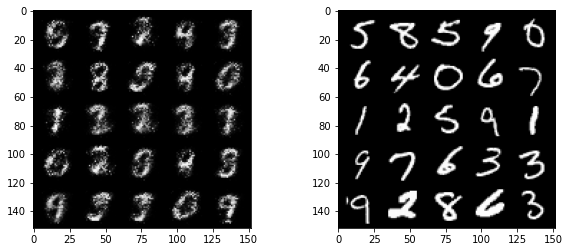

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 56 ,Step:6607 ,Generator loss: 3.7428784794726613 ,discriminator loss: 0.08303226164336933


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 57 ,Step:6725 ,Generator loss: 3.6919710252244595 ,discriminator loss: 0.09418354076096568


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 58 ,Step:6843 ,Generator loss: 3.7651159601696467 ,discriminator loss: 0.0902254661639868


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 59 ,Step:6961 ,Generator loss: 3.850827837394455 ,discriminator loss: 0.08543149511314042


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 60 ,Step:7079 ,Generator loss: 3.8389528908972017 ,discriminator loss: 0.08786561150672072


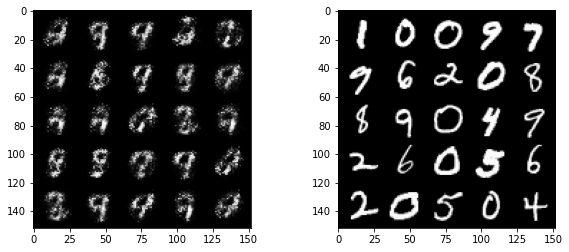

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 61 ,Step:7197 ,Generator loss: 3.8759903564291474 ,discriminator loss: 0.08818925468850938


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 62 ,Step:7315 ,Generator loss: 3.9782343254251025 ,discriminator loss: 0.08577443523553473


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 63 ,Step:7433 ,Generator loss: 4.092404777720823 ,discriminator loss: 0.082079601805594


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 64 ,Step:7551 ,Generator loss: 4.137390007406981 ,discriminator loss: 0.07839222151344107


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 65 ,Step:7669 ,Generator loss: 4.047367671788749 ,discriminator loss: 0.08836122905298814


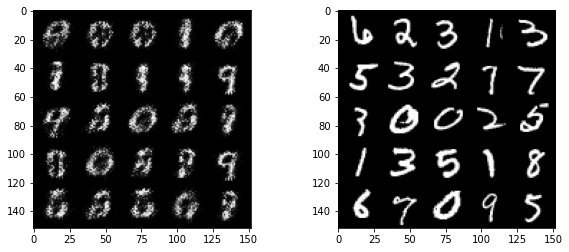

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 66 ,Step:7787 ,Generator loss: 3.9684716685343595 ,discriminator loss: 0.08368398302818758


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 67 ,Step:7905 ,Generator loss: 4.006590930082028 ,discriminator loss: 0.07487884268038354


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 68 ,Step:8023 ,Generator loss: 4.118144079790276 ,discriminator loss: 0.07597700487506595


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 69 ,Step:8141 ,Generator loss: 4.087271908582266 ,discriminator loss: 0.08543088631230897


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 70 ,Step:8259 ,Generator loss: 4.070380396762136 ,discriminator loss: 0.08937429463080432


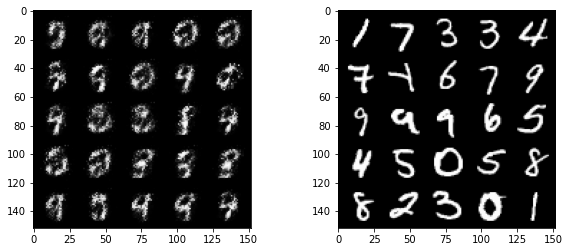

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 71 ,Step:8377 ,Generator loss: 4.162913443678518 ,discriminator loss: 0.08131783869180631


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 72 ,Step:8495 ,Generator loss: 4.145298125380176 ,discriminator loss: 0.08484203617830396


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 73 ,Step:8613 ,Generator loss: 4.05121445453773 ,discriminator loss: 0.10080717308288914


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 74 ,Step:8731 ,Generator loss: 4.00071189969273 ,discriminator loss: 0.10583549245434293


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 75 ,Step:8849 ,Generator loss: 4.033538347583706 ,discriminator loss: 0.09954565927638842


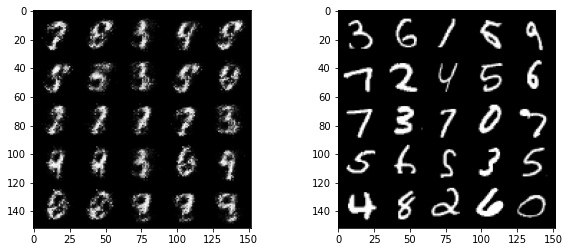

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 76 ,Step:8967 ,Generator loss: 4.118992546857413 ,discriminator loss: 0.09494401697637667


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 77 ,Step:9085 ,Generator loss: 3.995563430301213 ,discriminator loss: 0.10139657727490037


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 78 ,Step:9203 ,Generator loss: 3.95647071781805 ,discriminator loss: 0.09242873689380748


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 79 ,Step:9321 ,Generator loss: 4.0227664001917445 ,discriminator loss: 0.08629751199130285


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 80 ,Step:9439 ,Generator loss: 4.12612940901417 ,discriminator loss: 0.08076442291928551


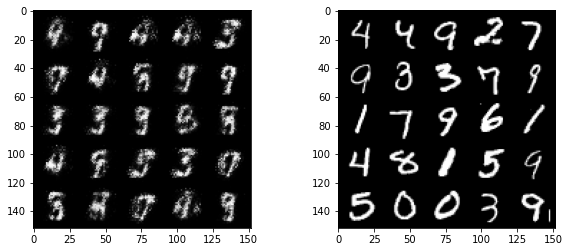

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 81 ,Step:9557 ,Generator loss: 4.1465573997820835 ,discriminator loss: 0.08677314379710264


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 82 ,Step:9675 ,Generator loss: 4.161771713677099 ,discriminator loss: 0.09043443013550868


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 83 ,Step:9793 ,Generator loss: 4.0957979489181 ,discriminator loss: 0.09863602085891415


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 84 ,Step:9911 ,Generator loss: 4.043456200825965 ,discriminator loss: 0.10428147567278248


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 85 ,Step:10029 ,Generator loss: 3.907689561278134 ,discriminator loss: 0.11499080510210187


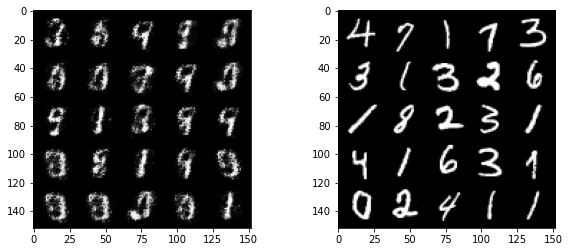

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 86 ,Step:10147 ,Generator loss: 3.8444648536585135 ,discriminator loss: 0.11441592651150989


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 87 ,Step:10265 ,Generator loss: 3.9596919791173137 ,discriminator loss: 0.10259725753281075


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 88 ,Step:10383 ,Generator loss: 3.9783737416994756 ,discriminator loss: 0.09452985618579184


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 89 ,Step:10501 ,Generator loss: 3.9650483737557622 ,discriminator loss: 0.09808695158463415


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 90 ,Step:10619 ,Generator loss: 3.944780380038894 ,discriminator loss: 0.09398115514698677


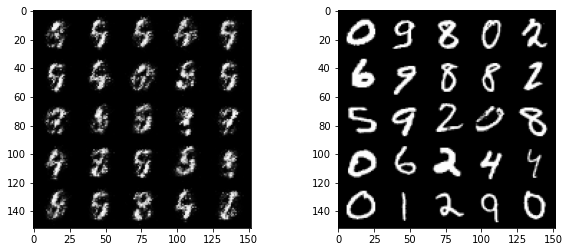

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 91 ,Step:10737 ,Generator loss: 4.019192174329597 ,discriminator loss: 0.08676030388954331


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 92 ,Step:10855 ,Generator loss: 4.1165122399895875 ,discriminator loss: 0.09257086688431644


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 93 ,Step:10973 ,Generator loss: 4.2264644170211545 ,discriminator loss: 0.09243714604211058


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 94 ,Step:11091 ,Generator loss: 4.252849320233879 ,discriminator loss: 0.09660119860101554


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 95 ,Step:11209 ,Generator loss: 4.12315955404508 ,discriminator loss: 0.11101115248718503


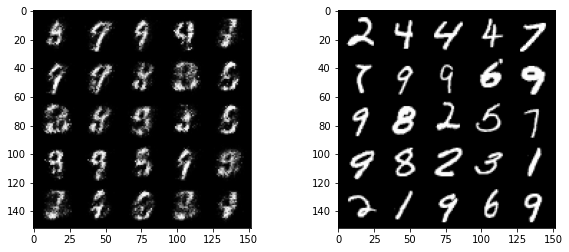

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 96 ,Step:11327 ,Generator loss: 4.121225585371762 ,discriminator loss: 0.10437175202167641


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 97 ,Step:11445 ,Generator loss: 4.118237477237896 ,discriminator loss: 0.10829061004569975


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 98 ,Step:11563 ,Generator loss: 3.934095750420779 ,discriminator loss: 0.11384393015907979


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 99 ,Step:11681 ,Generator loss: 3.9183861704195957 ,discriminator loss: 0.10396025847580477


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 100 ,Step:11799 ,Generator loss: 3.8725831124742145 ,discriminator loss: 0.10988441791574836


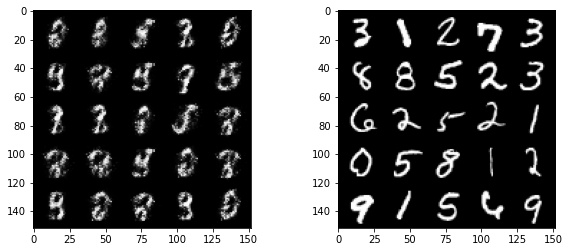

In [8]:
for epoch in range(1,n_epochs+1):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)
        ### Update discriminator ###
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / steps_per_ep
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / steps_per_ep
        cur_step += 1
        ### Visualization code ###
       
    print(f"Epoch: {epoch} ,Step:{cur_step-1} ,Generator loss: {mean_generator_loss} ,discriminator loss: {mean_discriminator_loss}")
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    
    if epoch % display_epoch == 0 and display_epoch > 1:
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        plt.figure(1, figsize=(10,4))
        plt.subplot(1,2,1)
        show_tensor_images(fake)
        plt.subplot(1,2,2)
        show_tensor_images(real)
        plt.show()
        
        
